<a href="https://colab.research.google.com/github/MasahiroAraki/MLCourse/blob/master/Python/answer/11a_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第11章 モデル推定

## 課題1

オリジナルの4次元のirisデータに対して各種のクラスタリングを行い、結果を評価してください。

4次元のデータなので可視化による結果の評価は適しません。ここでは異なるクラスタ数に対するシルエットスコアで評価します。

In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering, KMeans, AffinityPropagation
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

In [2]:
iris = load_iris()
X = iris.data

In [3]:
print("AgglomerativeClustering:")
for k in range(2,8):
    ac = AgglomerativeClustering(n_clusters=k, linkage='ward')
    ac.fit(X)
    print(f"# of clusters : {k}   score = {silhouette_score(X, ac.labels_):.2f}")

AgglomerativeClustering:
# of clusters : 2   score = 0.69
# of clusters : 3   score = 0.55
# of clusters : 4   score = 0.49
# of clusters : 5   score = 0.48
# of clusters : 6   score = 0.36
# of clusters : 7   score = 0.34


In [4]:
print("KMeans:")
for k in range(2,8):
    km = KMeans(n_clusters=k)
    km.fit(X)
    print(f"# of clusters : {k}   score = {silhouette_score(X, km.labels_):.2f}")

KMeans:
# of clusters : 2   score = 0.68
# of clusters : 3   score = 0.55
# of clusters : 4   score = 0.50
# of clusters : 5   score = 0.49
# of clusters : 6   score = 0.36
# of clusters : 7   score = 0.35


Affinity Propagationでは、自分に対する類似度 $s(x_i, x_i)$ の値を引数preferenceで設定することによってクラスタ数をコントロールします。類似度は2点間の距離の反数なので、負の値となります。0に近づくほどクラスタ中心になりやすくなり、結果としてクラスタ数が多くなります。

In [5]:
print("AffinityPropagation:")
for p in [-50, -20, -15, -10, -5]:
    ap = AffinityPropagation(preference=p, random_state=None)
    ap.fit(X)
    if len(ap.cluster_centers_indices_) == 1:
        continue
    print(f"# of clusters :{len(ap.cluster_centers_indices_)}  score = {silhouette_score(X, ap.labels_):.2f}")

AffinityPropagation:
# of clusters :3  score = 0.52
# of clusters :3  score = 0.56
# of clusters :5  score = 0.47
# of clusters :5  score = 0.45
# of clusters :8  score = 0.34


In [6]:
print("GaussianMixture :")
for k in range(2,8):
    gmm = GaussianMixture(n_components=k, covariance_type='full')
    gmm.fit(X)
    y = gmm.predict(X)
    print(f"# of clusters : {k}   score = {silhouette_score(X, y):.2f}")

GaussianMixture :
# of clusters : 2   score = 0.69
# of clusters : 3   score = 0.50
# of clusters : 4   score = 0.41
# of clusters : 5   score = 0.23
# of clusters : 6   score = 0.27
# of clusters : 7   score = 0.21


クラスタ数を指定する手法では、クラスタ数=2のものがもっとも良い結果となりました。Affinity Propagation では、preferenceの値を調整してもクラスタ数=2にするのが難しく、結果としてクラスタ数=3のものがもっとも良い結果となりました。もとのデータが3クラスなので、正解ラベルを用いて評価すると Affinity Propagation が良い結果となりますが、このデータに対して、たまたま良いpreferenceの値を引き当てているだけという可能性もあるので、評価は難しいところです。

In [7]:
from sklearn.metrics import adjusted_rand_score

ac = AgglomerativeClustering(n_clusters=2, linkage='ward').fit(X)
km = KMeans(n_clusters=2).fit(X)
ap = AffinityPropagation(preference=-20, random_state=None).fit(X)
gmm = GaussianMixture(n_components=2, covariance_type='full').fit(X)

print(f"AgglomerativeClustering: {adjusted_rand_score(iris.target, ac.labels_):.2f}")
print(f"KMeans: {adjusted_rand_score(iris.target, km.labels_):.2f}")
print(f"AffinityPropagation: {adjusted_rand_score(iris.target, ap.labels_):.2f}")
print(f"GaussianMixture: {adjusted_rand_score(iris.target, gmm.predict(X)):.2f}")

AgglomerativeClustering: 0.57
KMeans: 0.54
AffinityPropagation: 0.75
GaussianMixture: 0.57


## 課題2

scikit-learnのdiabetesデータに対して様々なクラスタリング手法を適用してみてください。diabetesデータは回帰用のデータ（事例数442）で、target値は 25-346 で値が高くなるほど悪化の可能性が高いことを示しています。生成したクラスタ間で、target値の平均に違いが生じているかどうかで評価を行ってください。他のクラスタと比較してtarget値の平均が突出して高くなるようなクラスタ（一定数以上の要素数をもつことが条件）を見つけることができれば成功です。


ライブラリの読み込み

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, KMeans, AffinityPropagation
from sklearn.mixture import GaussianMixture

データの読み込み

In [9]:
(X, t) = load_diabetes(return_X_y=True)

主成分分析を用いてデータをプロットします。はっきりしたクラスタが見えないので、それほど簡単な問題ではないことがわかります。

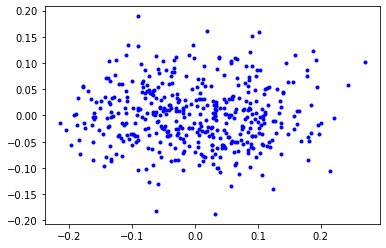

In [10]:
pca = PCA(n_components=2)
X2 = pca.fit_transform(X)
plt.plot(X2[:,0], X2[:,1],"b.")

ターゲット値の統計値

In [11]:
print("ave: %5.2f   std: %5.2f" % (np.average(t), np.std(t)))

ave: 152.13   std: 77.01


### 階層的クラスタリング

[AgglomerativeClustering](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)を用いて階層的クラスタリングを行います。クラスタ数を変化させて結果を観察してください。

In [12]:
ac=AgglomerativeClustering(n_clusters=5)
ac.fit(X)

AgglomerativeClustering(n_clusters=5)

クラスタ毎の事例数とtarget値の平均を表示します。

In [13]:
y = ac.labels_
for c in set(y):
    num = np.count_nonzero(y==c)
    ave = np.average(t[y==c])
    print("Cluster %d: num %3d, ave %5.2f" % (c, num, ave))

Cluster 0: num 118, ave 170.15
Cluster 1: num  84, ave 173.36
Cluster 2: num  98, ave 102.03
Cluster 3: num  83, ave 196.77
Cluster 4: num  59, ave 106.31


### k-meansクラスタリング

[KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)を用いて分割最適化クラスタリングを行います。クラスタ数は予め与えておく必要があります。

In [14]:
km = KMeans(n_clusters = 3)
km.fit(X)

KMeans(n_clusters=3)

クラスタ毎の事例数とtarget値の平均を表示します。

In [15]:
y = km.labels_
for c in set(y):
    num = np.count_nonzero(y==c)
    ave = np.average(t[y==c])
    print("Cluster %d: num %3d, ave %5.2f" % (c, num, ave))

Cluster 0: num 173, ave 109.52
Cluster 1: num 114, ave 189.99
Cluster 2: num 155, ave 171.85


 [AffinityPropagation](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html)はすべてのノード間で「類似度」と「クラスタ中心になりやすさ」の情報を交換しながらクラスタリングを行う手法です。クラスタ数（すなわちクラスタ中心の数）を事前に決める必要はありません。

 パラメータpreferenceは各データの中心としての選ばれやすさを表すので、負の値を設定すれば、その絶対値に応じてクラスタ数が少なくなります。

In [16]:
ap=AffinityPropagation(preference=-0.3, random_state=None)
ap.fit(X)

AffinityPropagation(preference=-0.3, random_state=None)

クラスタ毎の事例数とtarget値の平均を表示します。

In [17]:
y = ap.labels_
for c in set(y):
    num = np.count_nonzero(y==c)
    ave = np.average(t[y==c])
    print("Cluster %d: num %3d, ave %5.2f" % (c, num, ave))

Cluster 0: num  85, ave 193.99
Cluster 1: num  67, ave 182.13
Cluster 2: num  62, ave 109.24
Cluster 3: num  70, ave 105.86
Cluster 4: num  89, ave 118.99
Cluster 5: num  69, ave 199.68


### 確率密度推定

[GaussianMixture](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html)では、EMアルゴリズムを用いて混合分布によるクラスタリングを行います。クラスタ数を指定する必要があります。これまでのクラスと少しメソッドが異なるので注意してください。

In [18]:
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=1)
gmm.fit(X)

GaussianMixture(n_components=3, random_state=1)

クラスタ毎の事例数とtarget値の平均を表示します。

In [19]:
y = gmm.predict(X)
for c in set(y):
    num = np.count_nonzero(y==c)
    ave = np.average(t[y==c])
    print("Cluster %d: num %3d, ave %5.2f" % (c, num, ave))

Cluster 0: num 224, ave 111.17
Cluster 1: num 173, ave 185.79
Cluster 2: num  45, ave 226.64


初期値に乱数を用いるアルゴリズムは、実施毎に結果が異なります。GMMの例ではrandom_state=1で、事例数45、平均値226.64のクラスタが発見できていますが、他の値ではかなり異なる結果になります。